In [85]:
%pip install -r requirements.txt

In [1]:

%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers

from keras_preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from keras.applications import ResNet50

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import shutil

from PIL import Image

2024-01-05 17:21:53.318608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 17:21:53.318670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 17:21:53.373973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 17:21:53.490463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 17:21:55.001922: W tensorflow/compiler/tf2

In [3]:
"""
re = layers.Resizing(256,256)
resize_rescale = layers.Rescaling(1./255)(re)

pp = layers.RandomContrast(factor=0.1)
pp = layers.RandomFlip()(pp)
"""

#preprocessing = layers.RandomRotation(factor=0.2)(pp)

def conv_block(inputs, filters_n):
    n = layers.Conv2D(filters_n, 3, padding="same")(inputs)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    n = layers.Conv2D(filters_n, 3, padding="same")(n)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    return n

def encoder_block(inputs, filters_n):
    x = conv_block(inputs, filters_n)
    p = layers.MaxPool2D(pool_size=(2,2))(x)
    return x, p

def decoder_block(inputs, skip, filters_n):
    x = layers.Conv2DTranspose(filters_n, kernel_size=(2,2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters_n)
    return x


def U_Net(input_shape):
    inputs = layers.Input(shape=input_shape)
    inputs2 = layers.Rescaling(1. /255)(inputs)
    resnet50 = k.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs2)
    
    #encode
    """
    s1, out1 = encoder_block(resnet50, 64)
    s2, out2 = encoder_block(out1, 128)
    s3, out3 = encoder_block(out2, 256)
    s4, out4 = encoder_block(out3, 512)
    """
    s1 = resnet50.get_layer("input_1").output  ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output  ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output 

    #bottleneck
    #bottleneck = conv_block(out4, 1024)
    bottleneck = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    #decode
    decode1 = decoder_block(bottleneck, s4, 512)
    decode2 = decoder_block(decode1, s3, 256)
    decode3 = decoder_block(decode2, s2, 128)
    decode4 = decoder_block(decode3, s1, 64)
    
    #condense 
    outputs = layers.Conv2D(1,1, padding="same", activation="sigmoid")(decode4)
    model = k.Model(inputs=inputs, outputs=outputs, name="unet")
    print(type(model))
    
    return model

model = U_Net((256,256,3))
model.summary()
model.save_weights("model.h5")

<class 'keras.src.engine.functional.Functional'>
Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['rescaling_1[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                              

In [4]:
#classification

def classi(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding="same")(inputs)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    #classi layers
    for filters in [128, 256, 512]:
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    #output
    output = layers.Dense(7, activation=None)(x)

    model = k.Model(inputs=inputs, outputs=output, name="classification")
    return model

classification = classi((256,256,3))
classification.summary()

classification.save_weights("classification.h5")

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 activation_8 (Activation)   (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_8 (Bat  (None, 256, 256, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 128)     73856     
                                                                 
 activation_9 (Activation)   (None, 256, 256, 128)     0         
                                                    

In [52]:
def load_folder_imgs(folder, numimgs, startind, img_shape):
    images = []
    folderfiles = os.listdir(folder)
    for i in range(numimgs):
        if len(folderfiles) > i+startind+1: 
            img = cv2.imread(os.path.join(folder,folderfiles[i+startind]))
            #print(type(img))
            if img is not None:
                #print("before resize: " + str(type(img)))
                
                images.append(np.array(cv2.resize(img, dsize=img_shape)))
                #print(np.array(type(img)))
    """
    if None in images:
        print(images)
        print("none is in images")
    else:
        print("none is not in images")
    """
    return [images, i+startind]

#imagedatagenerator --> augments data, modify as wish
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             )

In [55]:
#process data for image_dataset_from_directory
def organize_images_to_classes(ds, new_path):
    
    for x in ds:
        if x != "image":
            path = os.path.join(new_path, x) 
            if not os.path.exists(path):
                os.mkdir(path)

    train_images = os.listdir(new_path)
    print(train_images)
    for i in range(len(train_images)): #iterates rows
        if i == 10015: # because range is being a tad bit silly right now
            break
        for x in ds:
            if ds.iloc[i][x] == 1:
                target_path = os.path.join(new_path,x)
                if not os.path.exists(os.path.join(target_path, train_images[i])) and train_images[i].endswith(".jpg"):
                    #permanently renames files to their locations (maybe bad?)
                    os.rename(os.path.join(new_path, train_images[i]), os.path.join(target_path, train_images[i])) 
                    break


    
    

In [62]:
classification.load_weights('classification.h5') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
classification.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["binary_accuracy", 'MeanSquaredError', 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy
batchsize=2500
spe = 50 #steps per epoch
epochs = 80
class_train = r"classi/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/" 
class_train_gt = pd.read_csv("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
#organize_images_to_classes(class_train_gt, class_train)

""" uncomment if u wanna use validation data for testing (kinda unnecessary because it's always being tested on new data but like ok)
class_val = r"classi/ISIC2018_Task3_Validation_Input/ISIC2018_Task3_Validation_Input/" 
class_val_gt = pd.read_csv("classi/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv")
organize_images_to_classes(class_val_gt, class_val)
"""

for i in range(epochs+1):
    train_ds = datagen.flow_from_directory(directory=class_train, target_size=(256,256), batch_size=batchsize) #preprocessed!! yippeee
    print(len(train_ds))

    history = classification.fit(x=train_ds, batch_size=len(train_ds), callbacks=callback_list, steps_per_epoch=spe, verbose=1)
    #model.fit_generator(generator=train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1)
    print(f"--------------- Done epoch {i} -----------------")

classification.save_weights("final_class.h5")



Found 9104 images belonging to 7 classes.
4


2024-01-05 12:37:52.266460: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1966080000 exceeds 10% of free system memory.


ValueError: in user code:

    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/metrics/confusion_metrics.py", line 1486, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 672, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, None, None, 7) and (None, None) are incompatible


In [83]:
model.load_weights('model.h5') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy", 'MeanSquaredError', 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy
batchsize=4
spe = 50 #steps per epoch
currentindx=0
currentindy=0
epochs = 80


for i in range(epochs+1):
    currentindy=currentindx
    gtx = load_folder_imgs("seg/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/", batchsize, currentindx, (256,256))
    gty = load_folder_imgs("seg/ISIC2018_Task1_Training_GroundTruth/ISIC2018_Task1_Training_GroundTruth/", batchsize, currentindy, (256,256))
    train_gt_X = gtx[0] 
    train_gt_y = gty[0]
    
    currentinx = gtx[1]
    currentiny = gty[1]
    
    train_gt_X = [x//255 for x in train_gt_X]
    train_gt_y = [x//255 for x in train_gt_y]
    train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in train_gt_y]
    print(np.array(train_gt_y).shape)
    train_gt_X = tf.stack(train_gt_X) 
    train_gt_y = tf.stack(train_gt_y)
    #print(f"gtx len: {len(train_gt_X)}, gty len: {len(train_gt_y)}")
    #print(f"gtx shape: {np.array(train_gt_X).shape}, gty shape: {np.array(train_gt_y).shape}")

    train_generator = datagen.flow(x=train_gt_X, y=train_gt_y, batch_size=batchsize)
    model.fit_generator(generator=train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1)
    print(f"--------------- Done epoch {i} -----------------")

model.save_weights("final_seg_res50.h5")



gtx shape: (4, 256, 256, 3), gty shape: (4, 256, 256, 3)
gtx len: 4, gty len: 4
(4, 256, 256)


/tmp/ipykernel_903/2417518817.py:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1)


50/50 [==============================] - 41s 5ms/step - loss: 0.9806 - binary_accuracy: 0.4044 - mean_squared_error: 0.3461 - auc: 0.4251
--------------- Done epoch 0 -----------------
gtx shape: (4, 256, 256, 3), gty shape: (4, 256, 256, 3)
gtx len: 4, gty len: 4
(4, 256, 256)
50/50 [==============================] - 1s 917us/step - loss: 0.7116 - binary_accuracy: 0.5703 - mean_squared_error: 0.2596 - auc: 0.7541
--------------- Done epoch 1 -----------------
gtx shape: (4, 256, 256, 3), gty shape: (4, 256, 256, 3)
gtx len: 4, gty len: 4
(4, 256, 256)


KeyboardInterrupt: 

In [10]:
os.listdir("seg/ISIC2018_Task1_Training_GroundTruth")

['ISIC2018_Task1_Training_GroundTruth']

In [38]:
model.save_weights('model.h5')

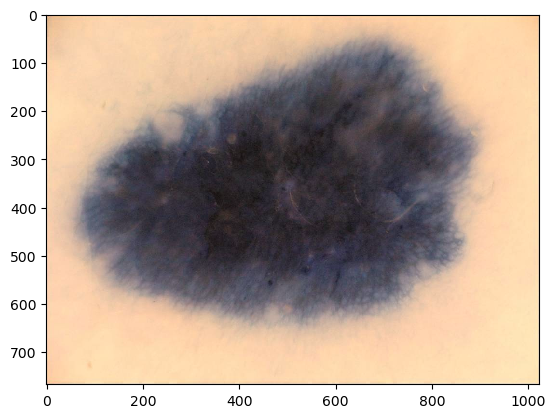

(256, 256, 3)


ValueError: in user code:

    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "unet" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(1, 256, 3)


In [68]:
pred_folder = "seg/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/"

pred_image = np.array(cv2.imread(os.path.join(pred_folder,"ISIC_0000000.jpg")))

plt.imshow(pred_image, interpolation='nearest')
plt.show()

pred_image = cv2.resize(pred_image, (256,256))
pred_image=pred_image//255
print(pred_image.shape)
#pred_image = tf.stack(pred_image)

pred = model.predict(pred_image, batch_size=1)

#img = mpimg.imread('your_image.png')
#imgplot = plt.imshow(img)
#plt.show()
plt.imshow(pred, interpolation='nearest')
plt.show() 

In [ ]:
#validation gt
#valid_gt_X = load_folder_imgs("seg/ISIC2018_Task1-2_Validation_Input")
#valid_gt_y = load_folder_imgs("seg/ISIC2018_Task1_Validation_GroundTruth")
model.evaluate(valid_gt, verbose=0, batch_size=32, steps=2)


NameError: name 'valid_gt' is not defined

In [ ]:
#train classification w/ U_net on full images
U_Net.trainable = False
classification.trainable = True

model.fit(x=train_ds_X, y=train_ds_y, epochs=10, batch_size=train_ds.length, callbacks=callback_list, verbose=2)

In [ ]:
#validation full

model.predict(valid_ds, verbose=0, batch_size=128, steps=2)


(256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
(128, 128, 3)
<class 'numpy.ndarray'>


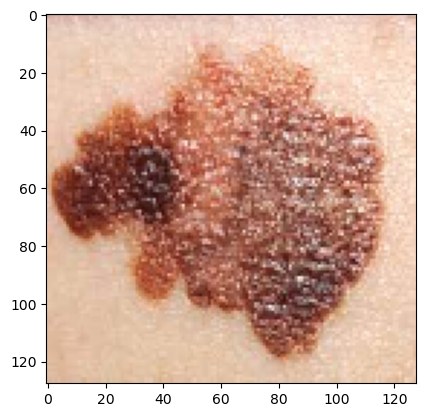

In [ ]:
img = Image.open("melanoma.jpg")
img = img.resize((256,256))
plt.imshow(img)
img = np.array(img)


test = Sequential([
    layers.InputLayer(shape=(256,256,3)),
    layers.MaxPooling2D(pool_size=(2,2))
])

test.compile('adam', 'binary_cross_entropy')
print(img.shape)
img2 = np.expand_dims(img, 0)

res = test.predict(img2, steps=1)
res.shape
res2 = res[0,:,:,:]
print(res2.shape)
plt.imshow((res2).astype(np.uint8)) # *255 to negative??
#plt.imshow(img)
print(type(res2[0][0]))

In [ ]:
#compilation code here
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy"]) # we can actually use metrics without matplotlib!!!! woww!!! i think

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy

#early stopping used to prevent overfitting

model.fit(train_ds, epochs=10, callbacks=callback_list)